In [4]:
import os
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import json
from collections import Counter
import requests

In [5]:
BASE_PATH = "../data/raw"
CHANNELS = ["blue", "green", "red", "yellow"]

def collect_image_paths(base_path=BASE_PATH):
    records = []
    for treatment_folder in os.listdir(base_path):
        treatment_path = os.path.join(base_path, treatment_folder)
        if not os.path.isdir(treatment_path):
            continue

        treatment = treatment_folder.split("-")[-1].lower()

        image_dict = {}
        for channel in CHANNELS:
            channel_path = os.path.join(treatment_path, channel)
            for img_path in glob(os.path.join(channel_path, "*.jpg")):
                # Extract base ID (strip _blue, _red, etc.)
                basename = os.path.basename(img_path).replace(f"_{channel}.jpg", "")
                image_dict.setdefault(basename, {"id": basename, "treatment": treatment})
                image_dict[basename][channel] = img_path

        records.extend(image_dict.values())

    return pd.DataFrame(records)

In [6]:
def load_rocrate_metadata_with_antibodies(base_path=BASE_PATH):
    metadata_records = []

    for treatment_folder in os.listdir(base_path):
        crate_path = os.path.join(base_path, treatment_folder, "ro-crate-metadata.json")
        if not os.path.isfile(crate_path):
            continue

        with open(crate_path, "r") as f:
            crate = json.load(f)

        # --- Build antibody/stain index ---
        antibody_index = {}
        for entry in crate.get("@graph", []):
            if entry.get("@type") == "BioChemEntity":
                stain_id = entry["@id"]
                identifiers = entry.get("identifier", [])
                if isinstance(identifiers, dict):
                    identifiers = [identifiers]

                id_map = {i.get("name"): i.get("value") for i in identifiers}

                antibody_index[stain_id] = {
                    "name": entry.get("name"),
                    "description": entry.get("description"),
                    "hpa_id": id_map.get("HPA Antibody ID"),
                    "ensembl": id_map.get("ENSEMBL"),
                    "uniprot": id_map.get("Uniprot"),
                    "pubchem": id_map.get("PubChem"),
                    "subcellular_location": (
                        entry.get("isLocatedInSubcellularLocation", {}).get("name")
                        if isinstance(entry.get("isLocatedInSubcellularLocation"), dict)
                        else None
                    )
                }

        # --- Process each dataset (image) entry ---
        for entry in crate.get("@graph", []):
            if entry.get("@type") != "EVI:Dataset":
                continue

            content_url = entry.get("contentUrl", "")
            filename = os.path.basename(content_url.replace("file://", "")).strip("/")
            if not filename.endswith(".jpg"):
                continue

            base_id = filename.replace(".jpg", "").rsplit("_", 1)[0]
            channel = filename.replace(".jpg", "").rsplit("_", 1)[-1].lower()

            stain_ref = entry.get("usedStain", {}).get("@id", "")
            stain_key = stain_ref.split("/")[-1].replace("stain-", "")
            ab_meta = antibody_index.get(stain_ref, {})

            metadata_records.append({
                "id": base_id,
                "channel": channel,
                "antibody_stain": stain_key,
                "antibody_name": ab_meta.get("name"),
                "antibody_hpa_id": ab_meta.get("hpa_id"),
                "antibody_ensembl": ab_meta.get("ensembl"),
                "antibody_uniprot": ab_meta.get("uniprot"),
                "antibody_pubchem": ab_meta.get("pubchem"),
                "subcellular_location": ab_meta.get("subcellular_location"),
                "cell_line": entry.get("usedCellLine", {}).get("@id", "").split("/")[-1].replace("cell-line-", ""),
                "treatment": entry.get("usedTreatment", {}).get("@id", "").split("/")[-1].replace("treatment-", ""),
                "description": entry.get("description", ""),
                "filename": filename
            })

    return pd.DataFrame(metadata_records)


In [7]:
def batch_lookup_ensembl_symbols(ensembl_ids, batch_size=1000):
    """
    Look up gene symbols from Ensembl using batched POST requests.
    Returns a dict {ensembl_id: gene_symbol}
    """
    url = "https://rest.ensembl.org/lookup/id"
    headers = {"Content-Type": "application/json"}
    id_to_symbol = {}

    for i in range(0, len(ensembl_ids), batch_size):
        batch = ensembl_ids[i:i + batch_size]
        payload = {"ids": batch}
        try:
            response = requests.post(url, headers=headers, json=payload)
            if response.status_code == 200:
                results = response.json()
                for eid, info in results.items():
                    id_to_symbol[eid] = info.get("display_name", None)
            else:
                print(f"⚠️ Error {response.status_code}: {response.text}")
        except Exception as e:
            print(f"⚠️ Request failed for batch starting at {i}: {e}")
    
    return id_to_symbol

In [8]:
def save_image_gene_node_attributes(df_merged, base_output_dir="data/raw"):
    # Filter to green channel (protein target)
    df_green = df_merged[df_merged["channel"] == "green"].copy()

    # Normalize treatment label: "control" becomes "untreated"
    df_green["treatment"] = df_green["treatment"].replace("control", "untreated")

    # Drop exact duplicates across key fields
    df_green = df_green.drop_duplicates(subset=["id", "treatment", "antibody_hpa_id", "antibody_ensembl"])

    # Group by treatment
    treatments = df_green["treatment"].dropna().unique()

    for treatment in treatments:
        df_t = df_green[df_green["treatment"] == treatment]

        df_out = pd.DataFrame({
            "name": df_t["antibody_name"],
            "represents": "ensembl:" + df_t["antibody_ensembl"].fillna(""),
            "ambiguous": df_t["antibody_hpa_id"],
            "antibody": df_t["antibody_hpa_id"],
            "filename": df_t["id"].astype(str) + "_",
            "imageurl": "no image url found"
        })

        unique_ensembl_ids = (
            df_out["represents"]
            .dropna()
            .str.replace("ensembl:", "", regex=False)
            .loc[lambda s: s.str.match(r"ENSG\d+")]  # keep only valid Ensembl Gene IDs
            .unique()
            .tolist()
        )

        ensembl_to_name = batch_lookup_ensembl_symbols(unique_ensembl_ids)

        df_out["name"] = (
            df_out["represents"]
            .str.replace("ensembl:", "", regex=False)
            .map(ensembl_to_name)
        )

        df_out["name"] = df_out["name"].fillna("NEGATIVE")

        # Save to the appropriate treatment folder
        treatment_folder = os.path.join(base_output_dir, treatment)
        os.makedirs(treatment_folder, exist_ok=True)

        out_path = os.path.join(treatment_folder, "1_image_gene_node_attributes.tsv")
        df_out.to_csv(out_path, sep="\t", index=False)

        print(f"✅ Saved: {out_path}")

In [9]:
def load_multichannel_image(row):
    """
    Loads a 4-channel immunofluorescence image from separate grayscale files.

    Args:
        row (pd.Series): A row from df_images with keys: blue, green, red, yellow.

    Returns:
        np.ndarray: H x W x 4 array with channels in the order [blue, green, red, yellow]
    """
    img_channels = []
    for ch in ["blue", "green", "red", "yellow"]:
        path = row[ch]
        img = Image.open(path).convert("L")  # Load as 8-bit grayscale
        img_array = np.array(img)
        img_channels.append(img_array)

    stacked = np.stack(img_channels, axis=-1)  # Shape: H x W x 4
    return stacked

In [10]:
def compute_stats_row(row):
    img = load_multichannel_image(row)
    results = []
    for i, ch in enumerate(CHANNELS):
        ch_data = img[..., i]
        results.append({
            "id": row["id"],
            "treatment": row["treatment"],
            "channel": ch,
            "mean": np.mean(ch_data),
            "std": np.std(ch_data),
            "min": np.min(ch_data),
            "max": np.max(ch_data),
        })
    return results

def compute_channel_stats_parallel(df, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(compute_stats_row)(row) for _, row in tqdm(df.iterrows(), total=len(df), desc="Parallel channel stats")
    )
    # Flatten nested list
    flat_results = [item for sublist in results for item in sublist]
    return pd.DataFrame(flat_results)

In [11]:
def print_summary_report(df_merged, n_jobs=4):
    print("🧬🔬 CM4AI Immunofluorescence Dataset Summary\n" + "="*45, flush=True)

    # 1. Number of treatments
    n_treatments = df_merged["treatment"].nunique()
    print(f"\n💊 Number of treatments: {n_treatments}", flush=True)
    for cond, count in df_merged["treatment"].value_counts().items():
        print(f"  - {cond}: {count} image-channel combinations", flush=True)

    # 2. Number of samples (unique image IDs) per treatment
    print("\n🧪 Number of unique samples per treatment:", flush=True)
    samples_per_treatment = (
        df_merged[["id", "treatment"]]
        .drop_duplicates()
        .groupby("treatment")
        .size()
    )
    for cond, count in samples_per_treatment.items():
        print(f"  - {cond}: {count} samples", flush=True)

    # 3. Image size distribution (parallelized)
    print("\n🖼 Image size distribution:", flush=True)

    # Reconstruct wide format for loading multichannel images
    df_channels = df_merged[["id", "channel", "filepath"]].drop_duplicates()
    df_shapes = df_channels.pivot(index="id", columns="channel", values="filepath").reset_index()
    df_treatments = df_merged[["id", "treatment"]].drop_duplicates()
    df_shapes = df_shapes.merge(df_treatments, on="id", how="left")

    def safe_load_shape(row):
        try:
            img = load_multichannel_image(row)
            return img.shape[:2]
        except Exception as e:
            print(f"  ⚠️ Error loading image for ID {row['id']}: {e}", flush=True)
            return None

    print("🔄 Computing image shapes in parallel...", flush=True)
    shapes = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(safe_load_shape)(row) for _, row in tqdm(df_shapes.iterrows(), total=len(df_shapes))
    )
    df_shapes["shape"] = shapes
    shape_counts = Counter([s for s in shapes if s is not None])
    for shape, count in shape_counts.items():
        print(f"  - {shape[0]}x{shape[1]}: {count} composite/multi-channel images", flush=True)

    # 4. Green channel antibody diversity
    green_df = df_merged[df_merged["channel"] == "green"]
    unique_green = sorted(set(green_df["antibody_hpa_id"].dropna().tolist()))
    print(f"\n🟩 Number of unique antibodies in green channel (protein target): {len(unique_green)}", flush=True)

    # 5. Red, Blue, Yellow antibody/stain names with icons
    print("\n🎯 Antibodies/stains used in other channels:", flush=True)

    channel_icons = {
        "red": "🟥",
        "blue": "🟦",
        "yellow": "🟨"
    }

    for ch in ["red", "blue", "yellow"]:
        ch_df = df_merged[df_merged["channel"] == ch]
        unique_ab = sorted(set(
            ch_df["antibody_hpa_id"].dropna().tolist() +
            ch_df["antibody_name"].dropna().tolist()
        ))
        icon = channel_icons.get(ch, "🔹")
        print(f"\n  {icon} {ch.upper()} channel antibodies/stains ({len(unique_ab)}):", flush=True)
        for ab in unique_ab:
            print(f"    - {ab}", flush=True)

    print("\n✅ Summary complete.\n", flush=True)


In [12]:
df_images = collect_image_paths()

In [13]:
with pd.option_context('display.max_colwidth', None):
    display(df_images[df_images.duplicated(subset="id", keep=False)].head())

,id,treatment,blue,green,red,yellow


In [14]:
df_meta = load_rocrate_metadata_with_antibodies()
df_images_melted = df_images.melt(
    id_vars=["id"],  # remove "treatment" here
    value_vars=["blue", "green", "red", "yellow"],
    var_name="channel",
    value_name="filepath"
)

df_merged = df_images_melted.merge(df_meta, on=["id", "channel"], how="left")

In [15]:
# TODO: Remove once image downloader integrated
save_image_gene_node_attributes(df_merged, base_output_dir=BASE_PATH)

✅ Saved: ../data/raw/paclitaxel/1_image_gene_node_attributes.tsv
✅ Saved: ../data/raw/untreated/1_image_gene_node_attributes.tsv
✅ Saved: ../data/raw/vorinostat/1_image_gene_node_attributes.tsv


In [16]:
print_summary_report(df_merged)

🧬🔬 CM4AI Immunofluorescence Dataset Summary

💊 Number of treatments: 3
  - vorinostat: 17848 image-channel combinations
  - paclitaxel: 17684 image-channel combinations
  - control: 15904 image-channel combinations

🧪 Number of unique samples per treatment:
  - control: 3976 samples
  - paclitaxel: 4421 samples
  - vorinostat: 4462 samples

🖼 Image size distribution:
🔄 Computing image shapes in parallel...


100%|██████████| 12859/12859 [02:42<00:00, 78.97it/s]


  - 2048x2048: 12859 composite/multi-channel images

🟩 Number of unique antibodies in green channel (protein target): 465

🎯 Antibodies/stains used in other channels:

  🟥 RED channel antibodies/stains (1):
    - Tubulin antibody

  🟦 BLUE channel antibodies/stains (1):
    - DAPI

  🟨 YELLOW channel antibodies/stains (1):
    - Calreticulin antibody

✅ Summary complete.



Parallel channel stats: 100%|██████████| 12859/12859 [04:10<00:00, 51.23it/s]


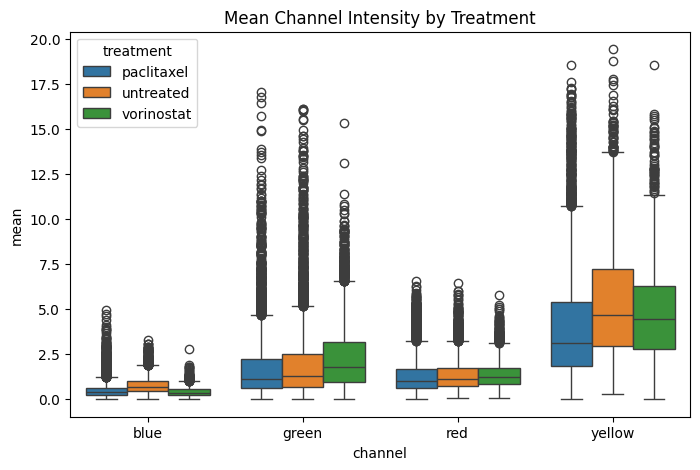

In [17]:
df_stats = compute_channel_stats_parallel(df_images)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_stats, x="channel", y="mean", hue="treatment")
plt.title("Mean Channel Intensity by Treatment")
plt.show()